# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [48]:
from sklearn import datasets
boston = datasets.load_boston()

In [49]:
import pandas as pd

In [50]:
boston_data = datasets.load_boston()
df_boston = pd.DataFrame(boston_data.data,columns=boston_data.feature_names)
df_boston['MEDV'] = pd.Series(boston_data.target)
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [51]:
print(boston.DESCR) #there are no missing values

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [52]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,8

<AxesSubplot:>

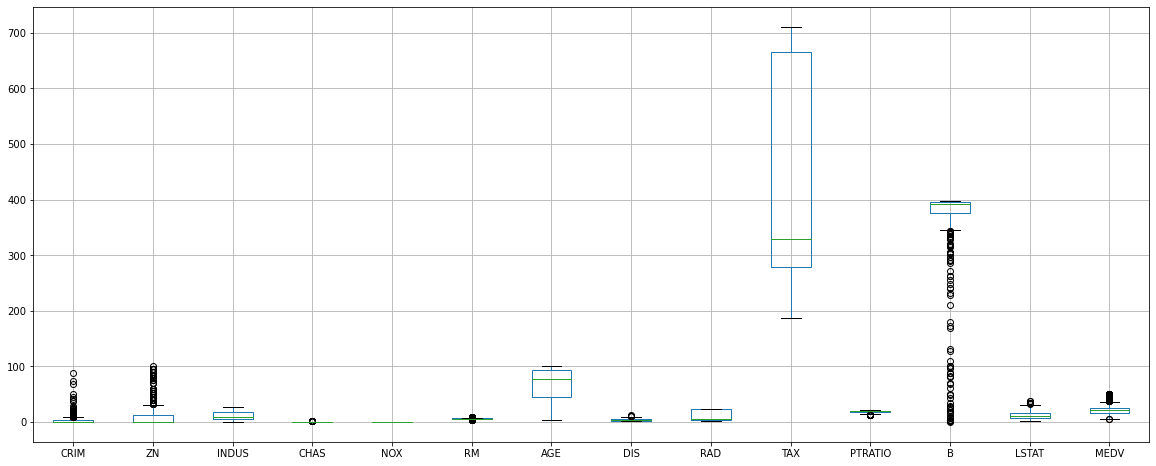

In [53]:
df_boston[list(df_boston.columns)].boxplot() #there are many ouliers in the variable "B" 

### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

In [54]:
import seaborn as sns 

<AxesSubplot:>

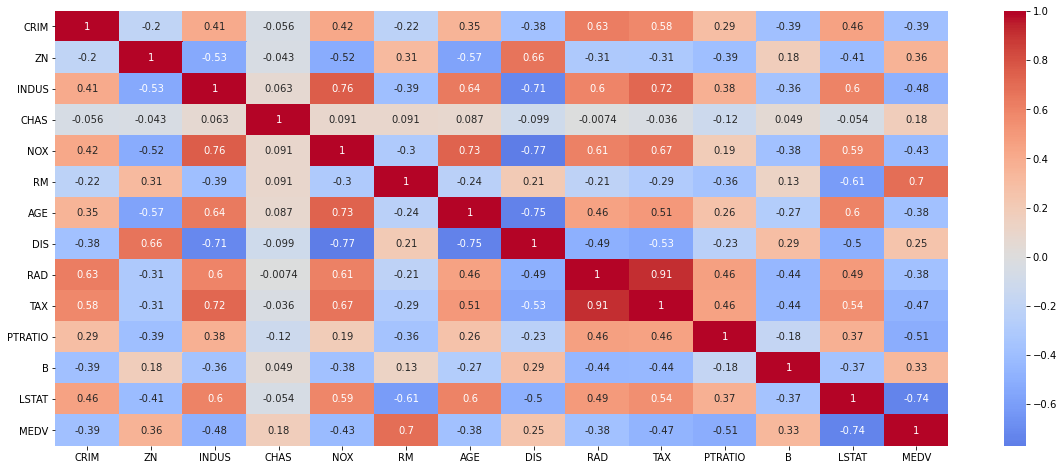

In [55]:
sns.heatmap(df_boston.corr(), center=0, cmap = "coolwarm", annot = True) 

In [56]:
list(df_boston.columns.drop("MEDV"))

['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

<AxesSubplot:xlabel='ZN', ylabel='MEDV'>

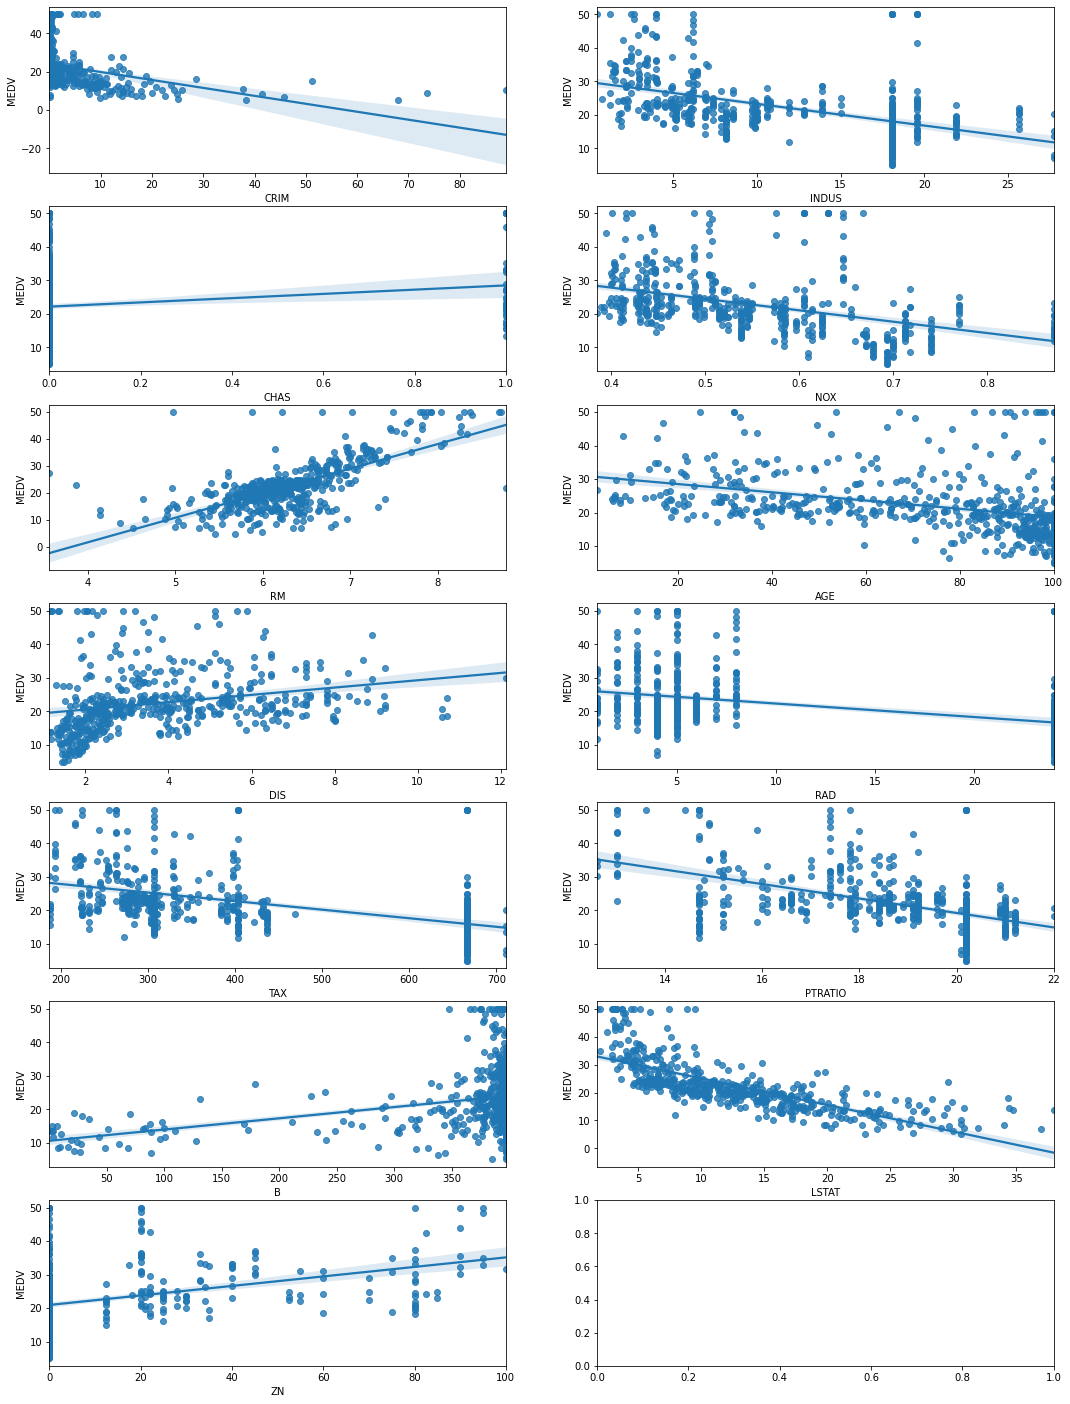

In [57]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(7,2 , figsize=(18, 25))
sns.regplot(ax=axes[0,0], data=df_boston, x = 'CRIM', y = "MEDV")
sns.regplot(ax=axes[0,1], data=df_boston, x = 'INDUS', y = "MEDV")
sns.regplot(ax=axes[1,0], data=df_boston, x = 'CHAS', y = "MEDV")
sns.regplot(ax=axes[1,1], data=df_boston, x = 'NOX', y = "MEDV")
sns.regplot(ax=axes[2,0], data=df_boston, x = 'RM', y = "MEDV")
sns.regplot(ax=axes[2,1], data=df_boston, x = 'AGE', y = "MEDV")
sns.regplot(ax=axes[3,0], data=df_boston, x = 'DIS', y = "MEDV")
sns.regplot(ax=axes[3,1], data=df_boston, x = 'RAD', y = "MEDV")
sns.regplot(ax=axes[4,0], data=df_boston, x = 'TAX', y = "MEDV")
sns.regplot(ax=axes[4,1], data=df_boston, x = 'PTRATIO', y = "MEDV")
sns.regplot(ax=axes[5,0], data=df_boston, x = 'B', y = "MEDV")
sns.regplot(ax=axes[5,1], data=df_boston, x = 'LSTAT', y = "MEDV")
sns.regplot(ax=axes[6,0], data=df_boston, x = 'ZN', y = "MEDV")

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [58]:
df_boston["MEDV"].describe()

count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: MEDV, dtype: float64

----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [59]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    return r2_score(y_true, y_predict) #I'm not really sure what I'm supposed to do here

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
X = df_boston.drop("MEDV", axis = 1)

In [62]:
y = df_boston["MEDV"]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.2,random_state=42, shuffle=True)

----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [64]:
from sklearn.ensemble import RandomForestRegressor

In [65]:
regr_2 = RandomForestRegressor(max_depth=2, random_state=0)
regr_4 = RandomForestRegressor(max_depth=4, random_state=0)
regr_6 = RandomForestRegressor(max_depth=6, random_state=0)
regr_8 = RandomForestRegressor(max_depth=8, random_state=0)
regr_10 = RandomForestRegressor(max_depth=10, random_state=0)

In [66]:
regr_2.fit(X_train, y_train)
regr_4.fit(X_train, y_train)
regr_6.fit(X_train, y_train)
regr_8.fit(X_train, y_train)
regr_10.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=0)

Now, plot the score for each tree on the training set and on the testing set.

In [67]:
y_pred2_train = regr_2.predict(X_train)
y_pred4_train = regr_4.predict(X_train)
y_pred6_train = regr_6.predict(X_train)
y_pred8_train = regr_8.predict(X_train)
y_pred10_train = regr_10.predict(X_train)

In [72]:
performance_metric(y_train, y_pred4_train)

0.908160917725168

In [73]:
performance_metric(y_train, y_pred6_train)

0.9474461232107966

In [74]:
performance_metric(y_train, y_pred8_train)

0.9655286114320853

In [75]:
performance_metric(y_train, y_pred10_train)

0.972015328970268

In [76]:
y_pred2 = regr_2.predict(X_test)
y_pred4 = regr_4.predict(X_test)
y_pred6 = regr_6.predict(X_test)
y_pred8 = regr_8.predict(X_test)
y_pred10 = regr_10.predict(X_test)

In [77]:
performance_metric(y_test, y_pred2)

0.7033586686941331

In [78]:
performance_metric(y_test, y_pred4)

0.8490295006393928

In [79]:
performance_metric(y_test, y_pred6)

0.8686112127553408

In [80]:
performance_metric(y_test, y_pred8)

0.8769548076205445

In [81]:
performance_metric(y_test, y_pred10)

0.8749927164972153

What do these results tell you about the effect of the depth of the trees on the performance of the model?

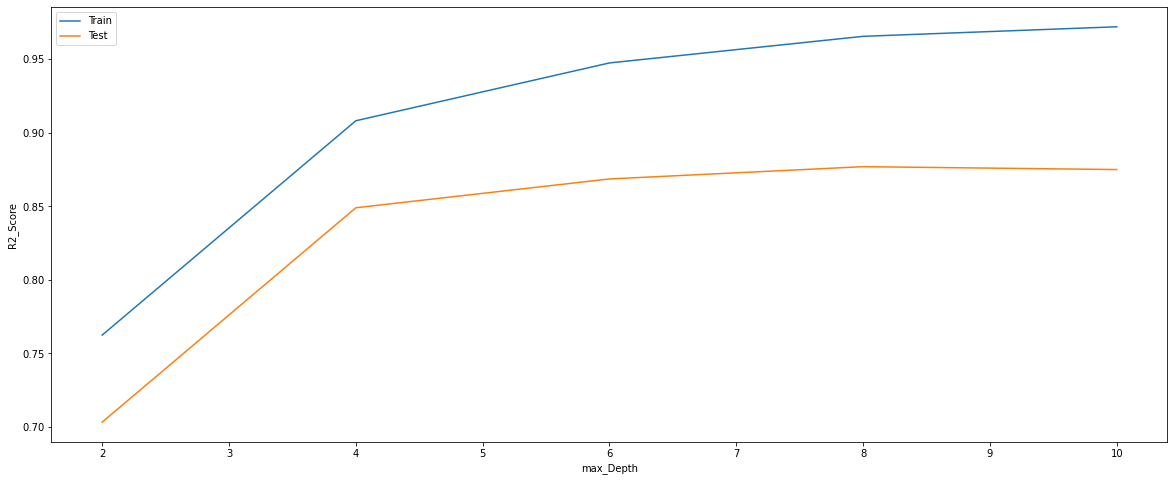

In [90]:
plt.plot([2,4,6,8,10], [performance_metric(y_train, y_pred2_train),performance_metric(y_train, y_pred4_train),performance_metric(y_train, y_pred6_train),performance_metric(y_train, y_pred8_train),performance_metric(y_train, y_pred10_train)])
plt.plot([2,4,6,8,10], [performance_metric(y_test, y_pred2),performance_metric(y_test, y_pred4),performance_metric(y_test, y_pred6),performance_metric(y_test, y_pred8),performance_metric(y_test, y_pred10)])
plt.xlabel("max_Depth")
plt.ylabel("R2_Score")
plt.legend(['Train',"Test"])

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10?

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [95]:
from sklearn.model_selection import GridSearchCV

In [96]:
model = RandomForestRegressor()

In [97]:
params = {'max_depth':range(1,15)}

In [98]:
model_sel = GridSearchCV(model, params)

In [99]:
model_sel.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 15)})

In [100]:
model_sel.best_estimator_

RandomForestRegressor(max_depth=10)

### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*